# 3) POS Pattern Frequency (Adj+N, V+N, etc.)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Analyze grammatical patterns in bigrams using Part-of-Speech (POS) tagging.
- Identify common POS patterns like ADJ+NOUN, VERB+NOUN, NOUN+NOUN across two works by the same author.
- Visualize the distribution of POS patterns to understand syntactic phrase structure.

Learning objectives:
- Apply spaCy POS tagging to tokenized text for grammatical analysis.
- Compute and compare POS bigram patterns across literary texts.
- Visualize syntactic patterns to identify stylistic features.
- Understand how preprocessing choices (stopwords, filtering) affect syntactic analysis.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. (Optional) Toggle `use_stopwords` to remove common function words.
3. Run cells from top to bottom. The main outputs are saved to `../results/`.
4. Ensure `en_core_web_sm` spaCy model is installed (included in requirements.txt).

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, spacy).
- spaCy English model: `en_core_web_sm` (should be installed via requirements.txt).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- POS tagging can be slow on large texts; consider slicing tokens or processing in chunks.
- Common patterns: ADJ+NOUN (descriptive phrases), VERB+NOUN (action phrases), NOUN+NOUN (compounds).
- Compare patterns between your two books to see if syntactic style differs.
- For non-English texts, change the spaCy model in the CONFIG or POS tagging cell (e.g., `de_core_news_sm` for German).

**Goal:** Identify and visualize the most frequent Part-of-Speech bigram patterns (e.g., ADJ+NOUN, VERB+NOUN) in your two selected works.


## LOAD AND CLEAN 

In [43]:
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/Crime-punishment.txt",          # Crime and Punishment    
    "language": "en",
    "use_stopwords": False,
    "min_ngram_count": 5,
    "top_k": 20,
    "char_json": "./Character Library/Crime_punishment.json"
}

# Unicode-aware word tokenizer
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)
STOPWORDS = {
    "the","a","an","and","or","but","if","so","because","as",
    "of","in","on","at","to","for","from","by","with","about",
    "this","that","these","those",
    "i","you","he","she","it","we","they","me","him","her","them",
    "my","your","his","her","its","our","their",
    "is","am","are","was","were","be","been","being",
    "do","does","did","have","has","had",
    "not","no","yes","there","here","then","than",
    "what","which","who","whom","whose","when","where","why","how",
    "up","down","out","into","over","under","again","further",
    "all","any","both","each","few","more","most","other","some","such",
}

In [44]:
def load_book(filepath: str) -> str:
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

CP_text = load_book('../data/Crime-punishment.txt')
BK_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"CP characters: {len(CP_text):,}")
import re
from typing import List

def split_chapters(text: str) -> List[str]:
    # Match "CHAPTER I", "CHAPTER II", ... or "CHAPTER 1", etc.
    pattern = re.compile(r'(CHAPTER\s+[IVXLCDM0-9]+(?:\s*[\w\s]*)?)', re.IGNORECASE)
    
    # Find all matches
    matches = list(pattern.finditer(text))
    
    chapters = []
    for i in range(len(matches)):
        start = matches[i].start()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        chapter_text = text[start:end].strip()
        if len(chapter_text) > 500:  # filter very small texts if necessary
            chapters.append(chapter_text)
    
    return chapters

CP_chapters = split_chapters(CP_text)
print("Chapters loaded:", len(CP_chapters))

CP characters: 1,211,652
Chapters loaded: 41


In [45]:
# Unicode-aware word tokenizer
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

STOPWORDS = set()  # keep empty unless you want them

def tokenize(text: str):
    tokens = WORD_RE.findall(text.lower())
    return [t for t in tokens if t not in STOPWORDS]


In [46]:
CP_chapter_tokens = []

for ch_text in CP_chapters:
    CP_chapter_tokens.append(tokenize(ch_text))

print("Tokenized chapters:", len(CP_chapter_tokens))
print("Sample tokens from chapter 1:", CP_chapter_tokens[0][:20])


Tokenized chapters: 41
Sample tokens from chapter 1: ['chapter', 'i', 'on', 'an', 'exceptionally', 'hot', 'evening', 'early', 'in', 'july', 'a', 'young', 'man', 'came', 'out', 'of', 'the', 'garret', 'in', 'which']


## Spiritual Library

In [50]:
religion_cp_terms = [
    # Explicit Chapter 5 concepts
    "excommunication",
    "church", "christ",
    "conscience",
    "mercy",
    "charity",
    "gospel",
    "mysticism",

    # Core theology
    "god","lord","jesus","faith","belief","religion",
    "saint","priest","monk","elder",

    # Moral struggle
    "sin","sinful","sinner","repent","repentance",
    "redemption","salvation","forgiveness",
    "guilt","shame","humility","sacrifice",

    # Soul & afterlife
    "soul","spirit","spiritual",
    "heaven","hell","damnation",
    "eternal","immortal",

    # Ritual
    "prayer","pray","confession","confess",
    "cross","blessing","fasting",

    # Judgment
    "divine","judgment","justice","punishment",

    # Dostoevskian ethics
    "suffering","atonement","good","evil",
    "miracle","grace","providence"
]


with open("./Character Library/Crime_punishment.json", "r", encoding="utf-8") as f:
    char_data = json.load(f)

# Extract aliases for Raskolnikov (normalize to strings only)
aliases = []
for a in char_data["Rodion_Raskolnikov"]["aliases"]:
    if isinstance(a, str):
        aliases.append(a.lower())
    elif isinstance(a, dict) and "text" in a:
        aliases.append(a["text"].lower())

# --- Filter chapters where Raskolnikov appears ---
raskolnikov_chapters = []
for chapter_tokens in CP_chapter_tokens:
    # check if any alias appears in this chapter
    if any(alias in chapter_tokens for alias in aliases):
        raskolnikov_chapters.append(chapter_tokens)

# Flatten tokens
raskolnikov_tokens = [t for chapter in raskolnikov_chapters for t in chapter]




###
religion_cp_set = set(religion_cp_terms)
from collections import Counter

all_CP_tokens = [t for chapter in CP_chapter_tokens for t in chapter]
religion_freq_CP = Counter(t for t in all_CP_tokens if t in religion_cp_set)

print("\nReligious vocabulary frequency in Crime and Punishment:\n")
for term, freq in religion_freq_CP.most_common(20):
    print(f"{term}: {freq}")
def religious_density(tokens, religion_set):
    if not tokens:
        return 0.0
    return sum(1 for t in tokens if t in religion_set) / len(tokens)



Religious vocabulary frequency in Crime and Punishment:

punishment: 389
good: 205
god: 113
soul: 32
suffering: 31
confess: 28
cross: 23
faith: 19
priest: 19
pray: 17
conscience: 17
lord: 16
mercy: 16
shame: 14
confession: 13
jesus: 13
elder: 11
sin: 11
forgiveness: 11
heaven: 10


In [51]:
num_chapters = len(CP_chapter_tokens)

cut1 = num_chapters // 3
cut2 = 2 * num_chapters // 3

early_tokens  = CP_chapter_tokens[:cut1]
middle_tokens = CP_chapter_tokens[cut1:cut2]
late_tokens   = CP_chapter_tokens[cut2:]


In [52]:
def phase_density(chapter_token_lists):
    vals = [religious_density(ch, religion_cp_set) for ch in chapter_token_lists]
    if len(vals) == 0:
        return 0.0
    return sum(vals) / len(vals)

early_density  = phase_density(early_tokens)
middle_density = phase_density(middle_tokens)
late_density   = phase_density(late_tokens)

print("\nSpiritual density:")
print("Early :", early_density)
print("Middle:", middle_density)
print("Late  :", late_density)



Spiritual density:
Early : 0.004496961222270659
Middle: 0.005827050047560445
Late  : 0.005439063926449323




## Graph: Raskolnikov’s Spiritual Development


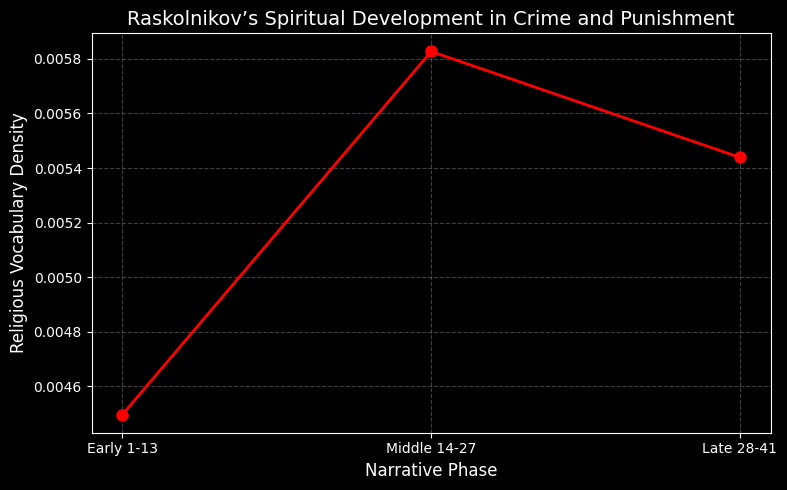

In [54]:
import matplotlib.pyplot as plt

phases = ["Early 1-13", "Middle 14-27", "Late 28-41"]
values = [early_density, middle_density, late_density]

plt.style.use('dark_background')  # dark theme
plt.figure(figsize=(8,5))
plt.plot(phases, values, color='red', marker='o', linewidth=2, markersize=8)

plt.xlabel("Narrative Phase", fontsize=12, color='white')
plt.ylabel("Religious Vocabulary Density", fontsize=12, color='white')
plt.title("Raskolnikov’s Spiritual Development in Crime and Punishment", fontsize=14, color='white')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')  # subtle grid

plt.tight_layout()
plt.show()
